In [62]:
import pathlib
import sys

sys.path.append("../")

from statespace import *

from typing import List, Optional, Dict
from dataclasses import dataclass
from pathlib import Path
from scipy.optimize import minimize, show_options

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import f as f_dist
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_breuschpagan, normal_ad    


@dataclass
class LocalLevelModel:
    '''
    Class implemeting the local level model
    '''
    
    data_path: Optional[Path] = None
    
    params: Dict[str, float] = None
    y, a, att, a_hat, p, ptt, f, v, k, r = None, None, None, None, None, None, None, None, None, None
    resid_diag = {}
    
    def __post_init__(self):
        
        if self.data_path:
            if self.data_path.exists():
                self.y = pd.read_csv(self.data_path, dtype=np.float64).values
            else:
                raise Exception('Path does not exist')
    
    def fit(self, y: Optional[np.ndarray] = None) -> None:
        '''
        Fits a local level model and extracts filter (a), in-casted filter (att), smoothed filter (a_hat)
        and all the other instance variables. 
        
                Parameters:
                        y (np.Array[float], Optional)     : Observed time series

                Returns:
                        None
        '''
        
        # If data added during construction, use that
        if self.y is not None:
            pass
        
        # If data not added during construction, should be passed to fit
        else: 
            if y is None:
                raise Exception('Need a data source')
            else:
                self.y = y.astype("float")


        # set options for minimization
        options = {
            'eps': 1e-6,
            'disp': True,
            'maxiter':500
        }

        # since estimating variances, must be greater than 0
        bnds = ((0, None), (0, None))

        # set initial values and construct array
        var_eta_ini = 500
        var_eps_ini = 500
        param_ini = np.array([var_eta_ini, var_eps_ini])

        # maximize log-likelihook
        res = minimize(self._llik, param_ini, args=(self.y, ), method='L-BFGS-B', options=options, bounds=bnds)

        # get best parameters
        params_dict = {'var_eta': res.x[0], 'var_eps': res.x[1]} 
        print(f'Parameters: {params_dict}')

        # update instance values
        self.a, self.att, self.p, self.ptt, self.f, self.v, self.k = self._kalman_filter(self.y, **params_dict)
        self.a_hat, self.r  = self._kalman_smoother(self.a, self.p, self.f, self.v, self.k, **params_dict)
        
    def residual_diagnostics(self, *args, **kwargs) -> List[Dict[str, float]]:
        '''
        Does residual diagnostics to assess model specification
        
                Parameters:
                        resid (np.Array[float], Optional)     : Observed time series

                Returns:
                        None
        
        '''
        
        v, f = None, None
        
        if self.v is None or self.f is None:
            raise Exception('model not yet fitted')
        else:
            v = self.v
            f = self.f
            
        # If an observation at time t is not present, should not include in diagnostics
        v = v[~np.isnan(v)]
        f = f[~np.isinf(f)]
        
        # standardize the residuals
        stand_resid = v / np.sqrt(f)
        
        H_dict = self._het_test(stand_resid, 1)
        N_dict = self._normal_test(stand_resid)
        Q_dict =self._serial_test(stand_resid, 10)

        print(H_dict)
        print(N_dict)
        print(Q_dict)
        
        return [H_dict, N_dict, Q_dict]
    
    def display_filters(self) -> None:
        '''
        Make a plot of all the filters
        '''
        fig, axs = plt.subplots(2,2)
        fig.set_size_inches(18,9)
        
        T = len(self.y)
        time = range(1871, 1871 + T)
        
        axs[0,0].plot(time, self.y, label=r'$y_t$')
        axs[0,0].plot(time, self.a, label=r'forecast $E(\alpha_t|Y_{t-1})$')
        axs[0,0].plot(time, self.att, label=r'now-cast $E(\alpha_t|Y_t)$')
        axs[0,0].plot(time, self.a_hat, label=r'smoothing $E(\alpha_t|Y_n)$')
        axs[0,0].set_title('All Filters: Nile Data')
        
        axs[0,1].plot(time, self.y, label=r'$y_t$')
        axs[0,1].plot(time, self.a, label=r'now-cast $E(\alpha_t|Y_{t-1})$')
        axs[0,1].set_title('Filtered State: Nile Data')
        
        axs[1,0].plot(time, self.y, label=r'$y_t$')
        axs[1,0].plot(time, self.att, label=r'now-cast $E(\alpha_t|Y_t)$')
        axs[1,0].set_title('In-casted State: Nile Data')
        
        axs[1,1].plot(time, self.y, label=r'$y_t$')
        axs[1,1].plot(time, self.a_hat, label=r'smoothing $E(\alpha_t|Y_n)$')
        axs[1,1].set_title('Smoothed State: Nile Data')
        
        for ax in axs.flatten().tolist():
            ax.grid()
            ax.legend()
            
    def display_decomposition(self) -> None:
        '''
        Decomposition of a time series into state and noise
        '''
       
        fig, axs = plt.subplots(3,1)
        fig.set_size_inches(14,10)
        
        T = len(self.y)
        time = range(1871, 1871 + T)
        
        axs[0].set_title('Decomposition of observed time series')
        axs[0].plot(self.y, label=r'observed $y_t$')
        axs[1].plot(self.a, color='g', label=r'level $\alpha_t$')
        axs[2].plot(self.v, color='r', label=r'error $v_t$')

        for ax in axs:
            ax.grid()
            ax.legend()
    
    def _get_nan_positions(self, y: np.ndarray) -> List[int]:
        '''
        Find positions of nan elements for the Kalman filter

                Parameters:
                        y (np.Array[float])     : Observed time series which might contain NaN

                Returns:
                        nan_pos_list (List[int]): List of NaN positions
        '''

        if y.ndim == 2:
            y = np.squeeze(y)

        nan_pos_list = np.squeeze(np.argwhere(np.isnan(y))).tolist()

        return nan_pos_list

    def _kalman_step(self, nan_pos_list: List[int], t: int, *args, **params):
        '''
        Computer one step of the kalman filter for the model
        y_t       = alpha_t + epsilon_t  w/ eps ~ N(0, var_eps)
        alpha_t+1 = alpha_t + eta_t      w/ eta ~ N(0, var_eta)

                Parameters:
                        args: variables filled in up until index t-1

                Returns:
                        args: variables filled in up until index t
        '''

        y, a, att, p, ptt, f, v, k = args

        # retrieve the parameters of the LL model
        var_eta = params['var_eta']
        var_eps = params['var_eps']

        # Always true
        a[t] = att[t-1]
        p[t] = ptt[t-1] + var_eta

        # If observation is present, proceed normally
        if t not in nan_pos_list:

            v[t] = y[t] - a[t]
            f[t] = p[t] + var_eps
            k[t] = p[t] / f[t]

            att[t] = a[t] + k[t] * v[t]
            ptt[t] = p[t] * (1 - k[t])

        # If observation is missing, update accordingly
        else:

            # variance -> inf because value unknown
            v[t] = np.nan
            f[t] = np.inf
            k[t] = 0

            # cannot keep k*v because it will equal nan (want 0)
            att[t] = a[t]
            ptt[t] = p[t]

        return a, att, p, ptt, f, v, k
    
    def _kalman_filter(self, y: np.ndarray, diffuse=True, *args, **params):
        '''
        Computer the kalman filter for a local level model given by
        y_t       = alpha_t + epsilon_t  w/ eps ~ N(0, var_eps)
        alpha_t+1 = alpha_t + eta_t      w/ eta ~ N(0, var_eta)

                Parameters:
                        y (np.Array[float])     : Observed time series
                        diffuse (Boolean)       : Whether or not to perform a diffuse initialization
                        params (Dict[str:float]): parameters state matrices

                Returns:
                        a (np.Array[float]): state mean estimate,  a[0] = a_0
                        p (np.Array[float]): state variance estimate, p[0] = p_0
                        f (np.Array[float]): prediction error, f[t] = var(v_t)
                        v (np.Array[float]): prediction variance, v[t] = y[t] - a[t]
                        k (np.Array[float]): Kalman gain, k[t] = p[t] / f[t]
        '''

        # retrieve the parameters of the LL model
        var_eta = params['var_eta']
        var_eps = params['var_eps']

        # get time horizon from data
        T = len(y)

        # get nan positions
        nan_pos_list = self._get_nan_positions(y)

        # initialize filters
        a, att, p, ptt, f, v, k = np.zeros(T), np.zeros(T), np.zeros(T), np.zeros(T), np.zeros(T), np.zeros(T), np.zeros(T)

        # REPLACE BY INIT FUNCTION?
        if diffuse:
            a[0] = 0
            p[0] = 1e20

        # Compute values at time t=1
        f[0] = p[0] + var_eps
        v[0] = y[0] - a[0]
        k[0] = p[0] / f[0]
        att[0] = a[0] + k[0] * v[0]
        ptt[0] = p[0] * (1 - k[0])

        # Compute values for t = 2,...,T
        for t in range(1, T):

            a, att, p, ptt, f, v, k = self._kalman_step(nan_pos_list, t, y, a, att, p, ptt, f, v, k, **params)

        #print(np.mean(f))
        return a, att, p, ptt, f, v, k
    
    def _kalman_smoother(self, *args, **params):
    
        '''
        Computer the kalman smoother for a local level model given by
        y_t   = alpha_t + epsilon_t  w/ eps ~ N(0, var_eps)
        m_t+1 = alpha_t + eta_t      w/ eta ~ N(0, var_eta)

        Where 
        r_{t-1} = v_t / f_t + L_t * r_t w/ r_n = 0
        a_hat_t = a_t + p_t * r_{t-1} 

                Parameters:
                        y (np.Array[float])     : Observed time series
                        diffuse (Boolean)       : Whether or not to perform a diffuse initialization
                        params (Dict[str:float]): parameters state matrices
                        f (np.Array[float]): prediction variance, f[t] = var(v_t)


                Returns:
                        a (np.Array[float]): state mean estimate,  a[0] = a_0
                        p (np.Array[float]): state variance estimate, p[0] = p_0
                        f (np.Array[float]): prediction error, v[t] = v_t
                        f (np.Array[float]): prediction variance, f[t] = var(v_t)
        '''

        # get output of kalman filter
        a, p, f, v, k = args

        # get L 
        l = 1 - k

        # get time horizon
        T = len(a)

        # r_T=0 not included, but need it in loop... shit
        r = np.zeros(T)

        # initialize r-and-smoother arrays, need r_0 for a_1, which is at index 0 of a
        r = np.zeros(T+1)
        a_hat = np.zeros(T)

        # a_hat[t]: contains a_hat_{t+1}
        # r[t]    : contains r_t

        # recursively compute smoothed state
        for t in range(T-1, -1, -1):

            if np.isnan(v[t]):
                r[t] = r[t+1]

            else:
                # should start at r_{T-1} at index T, and end at r_0 at index 0
                r[t] = v[t] / f[t] + l[t] * r[t+1]

            # a_hat_t = a_t + p_t * r_{t-1}
            # should start at a_hat{T} at index T-1, and end at a_1 at index 0
            a_hat[t] = a[t] + p[t] * r[t]

        return a_hat, r
    
    def _llik(self, params: np.ndarray, *args) -> float:
    
        '''
        Computes Gaussian log-likelihood for local level model
        y_t   = alpha_t + epsilon_t  w/ eps ~ N(0, var_eps)
        m_t+1 = alpha_t + eta_t      w/ eta ~ N(0, var_eta)

        Where 
        r_{t-1} = v_t / f_t + L_t * r_t w/ r_n = 0
        a_hat_t = a_t + p_t * r_{t-1} 

                Parameters:
                        params (np.ndarray)     : Contains parameters
                        args (tuple): contains y -> given my args in minimizer


                Returns:
                        -llik (float): value of log-likelihood for given parameters
        '''

        # retrieve parameters
        params_dict = {'var_eta': params[0], 'var_eps': params[1]} 

        # retrieve data
        y = args[0]

        # get values necessary from Kalman filter
        _, _, _, _, f, v, _ = self._kalman_filter(y, **params_dict)


        # If an observation at time t is not present, should not include in log-likelihood
        v = v[~np.isnan(v)]
        f = f[~np.isinf(f)]

        # Get the number of present observations
        T = len(f)

        # compute log-likelihood
        llik = np.sum( (-1/2) * ( T * np.log(np.pi) + np.log(f[1:]) + np.square(v[1:]) / f[1:]))

        return -llik
    
    def _het_test(self, resid: np.ndarray, diff_elem: int) -> Dict[str, float]:

        '''
        Heteroskedasticity test of residuals
        H0: residuals are homoskedastic
        H1: residuals are heteroskedastic
        
                Parameters:
                        resid (np.Array[float])     : standardized residuals

                Returns:
                        Dict[str, float]: Statistic and pvalue
        
        '''

        n = len(resid)

        # given p92 Commandeur Koopman book
        h = int((n - diff_elem) / 3)

        # test of variance, take squares
        square_resid = np.square(resid)

        # compute top and bottom of F-statistic
        num = np.sum(square_resid[n - h: n - 1])
        denom = np.sum(square_resid[diff_elem: diff_elem + h - 1])

        # notice that len(num)=len(denom), so F-statistic is num/denom (no dof's)
        F_stat = num / denom

        H = None
        if F_stat > 1:
            p_val = f_dist.cdf(F_stat, h, h)
        else:
            p_val = f_dist.cdf(1 / F_stat, h, h)

        return {'F_stat': F_stat, 'p_val': p_val}
    
    def _normal_test(self, resid: np.ndarray) -> Dict[str, float]:
        """
        Normality test of residuals
        H0: residuals are normally distributed
        H1: residuals are not normally distributed
        
                Parameters:
                        resid (np.Array[float])     : standardized residuals

                Returns:
                        Dict[str, float]: Statistic and pvalue
        
        """

        # get statistic and p_value
        N_stat, p_val = normal_ad(resid)

        return {'N_stat': N_stat, 'p_val': p_val}
    
    def _serial_test(self, resid: np.ndarray, lags: int) -> Dict[str, float]:
        """
        Normality test of residuals
        H0: residuals are serially uncorrelated
        H1: residuals are serially correlated
        
                Parameters:
                        resid (np.Array[float])     : standardized residuals

                Returns:
                        Dict[str, float]: Statistic and pvalue
        
        """

        # acorr_ljungbox expects lags as array
        lags = np.array([lags])

        # perform test, returns dataframe
        S_df = acorr_ljungbox(resid, lags=lags)

        # store values 
        Q_stat = S_df['lb_stat'].item()
        p_val = S_df['lb_pvalue'].item()

        return {'Q_stat': Q_stat, 'p_val': p_val}

In [63]:
base_dir = pathlib.Path().resolve().parent
data_dir = base_dir / 'data'
nile_path = data_dir / 'Nile.txt'
llm = LocalLevelModel(nile_path)
llm.fit()
llm.att

Parameters: {'var_eta': 1412.2860719525622, 'var_eps': 15301.476713910395}


array([1120.        , 1137.99614532, 1076.47168422, 1117.52076335,
       1129.65152965, 1137.97430566, 1050.80850961, 1098.29200948,
       1169.81505567, 1161.99508979, 1118.28183772, 1070.35714309,
       1080.71687543, 1058.06275183, 1048.12089677, 1025.10624313,
       1065.55793393,  995.9462806 ,  986.03675731, 1026.24331516,
       1045.50433198, 1088.46105898, 1104.53143853, 1142.51930745,
       1173.19837143, 1185.42020807, 1144.83358282, 1133.12568638,
       1039.34317049,  987.286455  ,  957.70269411,  888.83905632,
        902.19928647,  884.1285019 ,  836.30610559,  857.11746461,
        813.99849218,  867.7939726 ,  915.37547277,  929.37904602,
        903.68822415,  857.28650853,  752.4940692 ,  771.16721359,
        753.10480461,  848.91625525,  914.48456499,  892.94444693,
        859.27173966,  849.27741174,  828.05253112,  832.47821344,
        840.70985052,  846.26958565,  807.55028852,  817.32995102,
        798.1804798 ,  797.6110667 ,  860.90880297,  834.29621

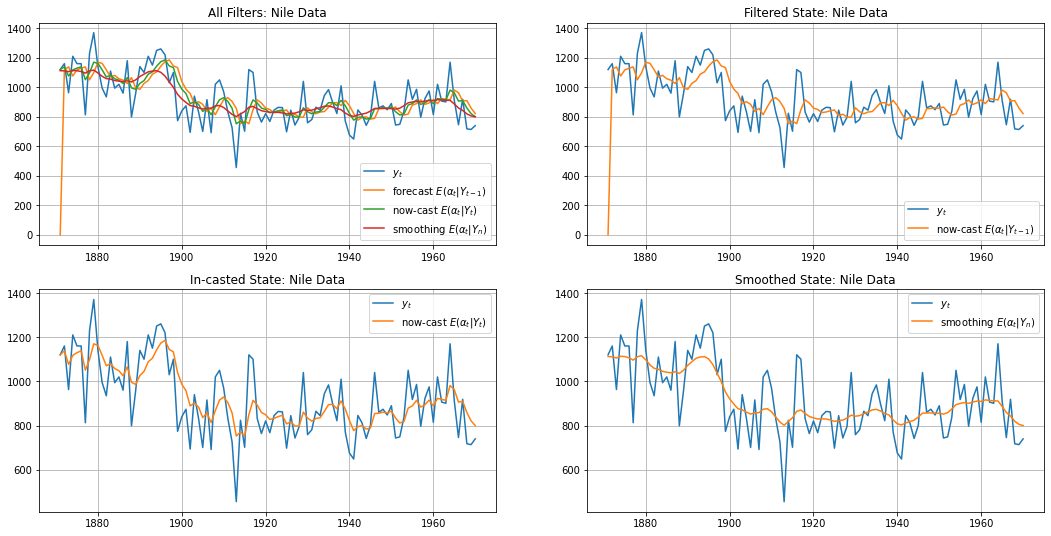

In [64]:
llm.display_filters()

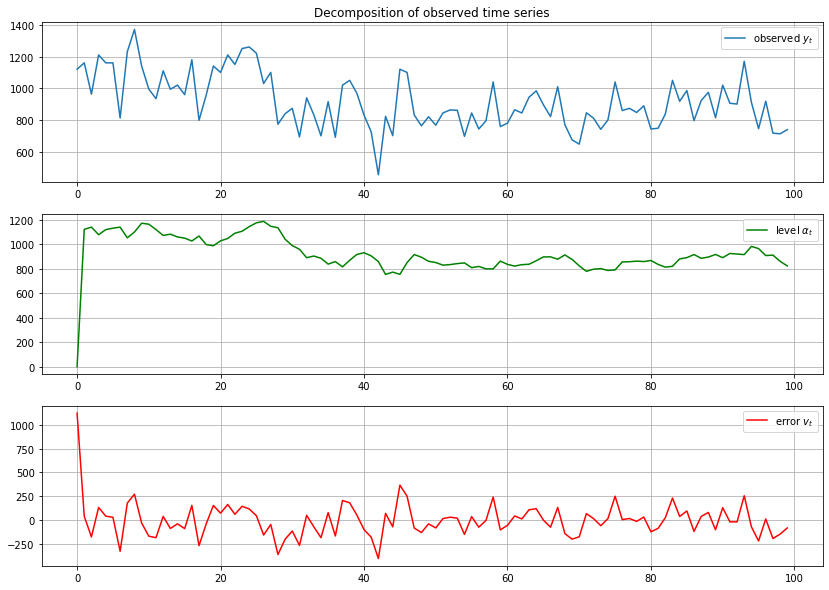

In [65]:
llm.display_decomposition()